In [ ]:
import re
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import PIL

import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import DenseNet121, DenseNet201

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pydicom 
from tqdm import tqdm
import missingno as msno 
from sklearn.metrics import roc_curve, roc_auc_score, auc
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from functools import partial
from kaggle_datasets import KaggleDatasets

base_dir = '/kaggle/input/siim-isic-melanoma-classification/'
external_base_dir = '/kaggle/input/melanoma-external-malignant-256/'
external_tfrec_base_dir = '../input/melanoma-256x256'

sns.set(style="darkgrid")
random.seed(42)

# 2. Initialize notebook parameters

Here will will initializer the TPUs or GPUs depending on the setup.

We will also set up some constants, like image size.

In [ ]:
DEVICE = 'GPU'

In [ ]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
N_CHANNELS = 3
epochs = 20
BATCH_SIZE = 8 * REPLICAS
IMAGE_SIZE = [IMG_HEIGHT, IMG_WIDTH]
IMAGE_RESIZE = [IMG_HEIGHT, IMG_WIDTH]
input_shape = (IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)
BALANCE_DATA = True
aug_data = True
NETWORK_MODEL = 'DenseNet201'

# 3. Getting images ready for the model

Depending on the devices being used we need to change the data path.

TPUs need to be fed from Google Cloud Storage

In [ ]:
if DEVICE == 'TPU':
    files_dir = KaggleDatasets().get_gcs_path('melanoma-256x256')
else:
    files_dir = external_tfrec_base_dir

In [ ]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(files_dir + '/train*.tfrec'),
    test_size=0.1, random_state=42
)
TEST_FILENAMES = tf.io.gfile.glob(files_dir + '/test*.tfrec')
print('Train TFRecord Files:', len(TRAINING_FILENAMES))
print('Validation TFRecord Files:', len(VALID_FILENAMES))
print('Test TFRecord Files:', len(TEST_FILENAMES))

submission_example = pd.read_csv(base_dir + 'sample_submission.csv')

Train TFRecord Files: 13
Validation TFRecord Files: 2
Test TFRecord Files: 16


In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [ ]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 180. * tf.random.normal([1],dtype='float32')
    shr = 2. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/8.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/8.
    h_shift = 8. * tf.random.normal([1],dtype='float32') 
    w_shift = 8. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTO)
    return dataset

def augmentation_pipeline(image, label):
    """
    add augmentation functions here
    """
    if aug_data:
        image,_ = transform(image,label)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_hue(image, 0.01)
        image = tf.image.random_saturation(image, 0.7, 1.3)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_brightness(image, 0.1)
        
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(augmentation_pipeline, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [ ]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE 
print("Num of steps per epoch:", STEPS_PER_EPOCH)
print("Num of steps per validation", VALID_STEPS)
print(
    'Dataset: {} training images, {} validation images, {} unlabeled test images'.format(
        NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES
    )
)

Num of steps per epoch: 3541
Num of steps per validation 544
Dataset: 28333 training images, 4359 validation images, 10982 unlabeled test images


Training data examples...


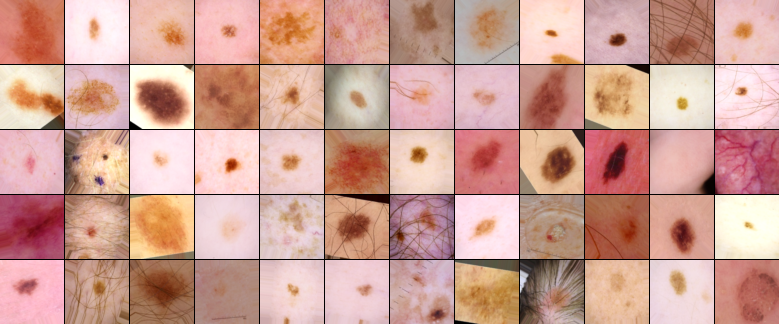

Validation data examples...


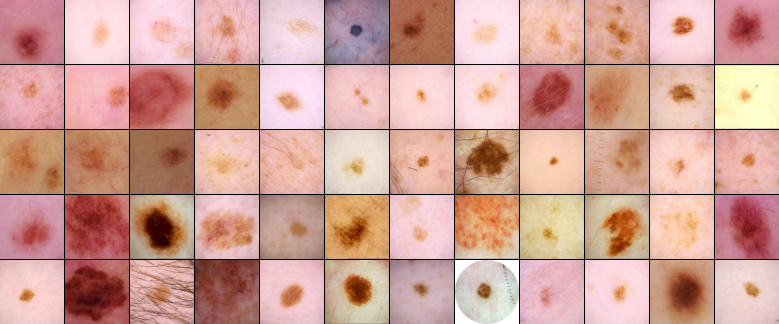

In [ ]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)
    
print("Training data examples...")
ds = train_dataset.unbatch().take(12*5)  
show_dataset(64, 12, 5, ds)
print("Validation data examples...")
ds = valid_dataset.unbatch().take(12*5)  
show_dataset(64, 12, 5, ds)

# 4. Train the model

In [ ]:
def plot_roc(y_true, y_score):
    """
    """
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_train_hist(hist):
    # Plot training & validation accuracy values
    plt.plot(hist.history['auc'])
    plt.plot(hist.history['val_auc'])
    plt.title('Model accuracy')
    plt.ylabel('Auc')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## 4.1 DenseNet transfer learning

Some callbacks for stopping the training process if validation loss stops decreasing. And a learning rate reduction during training

In [ ]:
learning_rate_reduction =ReduceLROnPlateau( 
    monitor='loss',    # Quantity to be monitored.
    factor=0.25,       # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=2,        # The number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,         # 0: quiet - 1: update messages.
    mode="auto",       # {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; 
                       # in the max mode it will be reduced when the quantity monitored has stopped increasing; 
                       # in auto mode, the direction is automatically inferred from the name of the monitored quantity.
    min_delta=0.0001,  # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,        # number of epochs to wait before resuming normal operation after learning rate (lr) has been reduced.
    min_lr=0.00001     # lower bound on the learning rate.
    )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

In [ ]:
def get_lr_callback():
    lr_start   = 0.000003
    lr_max     = 0.000020 * REPLICAS
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [ ]:
def get_model():
    
    model_input = tf.keras.Input(shape=input_shape, name='input_layer')
    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)    
    outputs = []    

    
    x = DenseNet201(include_top=False, weights='imagenet', 
                    input_shape=input_shape, 
                    pooling='avg')(dummy)

    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)
    
    model = tf.keras.Model(model_input, outputs, name='transfNetwork')
    model.summary()
    
    return model

In [ ]:
# create the base pre-trained model

model = get_model()

model.compile(optimizer='adam', loss=BinaryCrossentropy(label_smoothing=0.05),
              metrics=['AUC'])

# train the model on the new data for a few epochs
hist_train = model.fit(train_dataset,
                 validation_data=valid_dataset,
                 steps_per_epoch=STEPS_PER_EPOCH,
                 validation_steps=VALID_STEPS,
                 epochs=epochs,callbacks=[get_lr_callback()], class_weight=class_weights)

74842112/74836368 [==============================] - 1s 0us/step
Model: "transfNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/20
3541/3541 [==============================] - 562s 159ms/step - loss: 0.5848 - auc: 0.7815 - val_loss: 0.5798 - val_auc: 0.8439 - lr: 3.0000e-06
Epoch 2/20
35

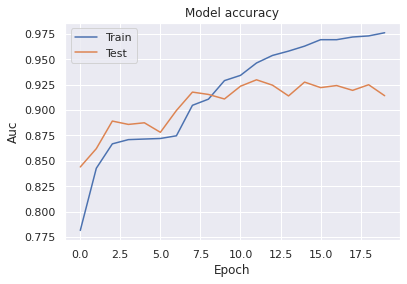

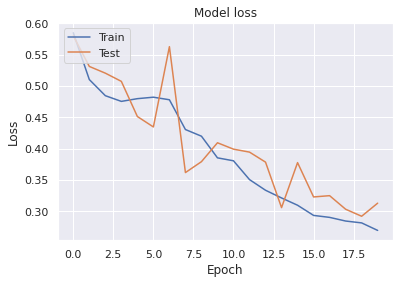

In [ ]:
plot_train_hist(hist_train)

# 5. Create predictions csv¶

In [ ]:
test_ds = get_test_dataset(ordered=True)
test_images_ds = test_ds.map(lambda image, idnum: image)

In [ ]:
probabilities = model.predict(test_images_ds)

In [ ]:
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

In [ ]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

,image_name,target
0,ISIC_9086006,0.013505
1,ISIC_1848625,0.020415
2,ISIC_3812398,0.069682
3,ISIC_0479755,0.371836
4,ISIC_3815385,0.001387


In [ ]:
del submission_example['target']
submission_example = submission_example.merge(pred_df, on='image_name')
#sub.to_csv('submission_label_smoothing.csv', index=False)
submission_example.to_csv('submission_densenet.csv', index=False)
submission_example.head()

,image_name,target
0,ISIC_0052060,0.141338
1,ISIC_0052349,0.001491
2,ISIC_0058510,0.000933
3,ISIC_0073313,0.009776
4,ISIC_0073502,0.008035
